# Milestone Project

The goal is to simulate the quantum adiabatic algorithm solving a small instance of maximum independence set on the graph defined by the adjacency matrix $M$, where

$$ 
M = \begin{pmatrix}
0 & 1 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 \\
0 & 0 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 
\end{pmatrix}  
$$

### Method
1. Construct $H_{\mathrm{Ising}}$ for this graph
2. Verify that the lowest energy state is indeed the maximum independent set $|10011\rangle$, which is represented by a column vector of length $2^5$ with a one in the 19<sup>th</sup> position, and zeros elsewhere
3. Simulate an adiabatic algorithm solving the problem with a time dependent Hamiltonian 


#### Import necessary libraries

In [2]:
import numpy as np
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from functools import partial
from IPython.display import HTML

#### Helper functions

In [3]:
pauli_matrices = {
    'x':np.matrix(([0, 1], [1, 0])),
    'y':np.matrix(([0, -1j], [1j, 0]), dtype=complex),
    'z':np.matrix(([1, 0], [0, -1]))
}

def generate_sigma_j(j: int, axis: str, n:int) -> np.matrix:
    """
    Inputs:
    j: the qubit being operated on
    axis: x, y or z 
    n: number of qubits in the system
    Returns:
    Matrix representation of the axis pauli operation
    on the jth qubit
    """
    # Set pauli matrix according to input axis
    sigma = pauli_matrices[axis]
    
    # Initialise sigma_j as 1
    sigma_j = 1

    # Iterate through to n
    for i in range(n):
        if i == j:
            sigma_j = np.kron(sigma_j, sigma)
        else:
            sigma_j = np.kron(sigma_j, np.identity(2))
    
    return sigma_j

print(generate_sigma_j(1, 'z', 3))

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1. -0.  0.  0. -0. -0.]
 [ 0.  0. -0. -1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0. -0.  0.  0. -1. -0.]
 [ 0.  0. -0. -0.  0.  0. -0. -1.]]


#### 1. Construct $H_{\mathrm{Ising}}$
$$
H_{\mathrm{Ising}} = \sum_{k = 1}^n \sum_{j = k + 1} ^ n J_{kj} \sigma_k^z \sigma_j^z + \sum_{j=1}^n h_j \sigma_j^z,
$$
where $J = M$, and
$$
h_k = -\sum_{j=1}^n(M_{kj} + M_{jk}) + \kappa
$$

In [4]:
def generate_strengths(M: np.matrix, kappa:float) -> tuple[np.matrix, np.ndarray]:
    """
    Inputs are M the adjacancy matrix and kappa the variable that rewards
    more independence
    Returns J and h, the coupling and field strengths respectively
    """
    # Set n to be the number of qubits in the system
    n = M.shape[0]

    # Initialise h as an array of kappas
    h = np.ones((n)) * kappa

    # Generate h - TODO method could probably be vectorised
    for k in range(n):
        for j in range(n):
            h[k] += -(M[k, j] + M[j, k])
    
    return M, h

def construct_H_ising(J: np.ndarray, h: np.ndarray) -> np.matrix:
    """
    Inputs: J and h are the coupling and field strengths respectively
    Returns: The Ising Hamiltonian, a 2^n x 2^n matrix
    """
    n = h.size
    H_ising = np.zeros((2**n, 2**n))

    # Add the first sum
    for k in range(n):
        for j in range(k + 1, n):
            sigma_j = generate_sigma_j(j, 'z', n)
            sigma_k = generate_sigma_j(k, 'z', n)
            H_ising += J[k, j] * sigma_k * sigma_j
    
    # Add the second sum
    for j in range(n):
        sigma_j = generate_sigma_j(j, 'z', n)
        H_ising += h[j] * sigma_j

    return H_ising

##### Test these functions with the example from the project book.

For the three qubit problem defined by the graph represented by the adjacency matrix

$$
M = \begin{pmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0 
\end{pmatrix}
$$

we can check if our functions generate the expected Ising Hamiltonian.

In [5]:
kappa_test = 0.5
M_test = np.matrix([
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 0]
])
expected_h_test = np.diag(np.array([
    -2 + 3*kappa_test, 
    -2 + kappa_test,
    -2 + kappa_test, 
    2 - kappa_test,
    -2 + kappa_test,
    -2 - kappa_test,
    2 - kappa_test,
    6 - 3*kappa_test
]))

J_test, h_test = generate_strengths(M_test, kappa_test)

if np.array_equal(h_test, np.array([-0.5, -1.5, -0.5])):
    print("Test 1 passed! Generated correct field strengths.")
else:
    print(f"Test 1 failed, expected\n {np.array([-0.5, -1.5, -0.5])},\n got {h_test}")

my_h_test = construct_H_ising(J_test, h_test)

if np.array_equal(my_h_test, expected_h_test):
    print("Test 2 passed! Generated correct Ising Hamiltonian.")
else:
    print(f"Test failed, expected \n {expected_h_test},\n got \n {my_h_test}.")

Test 1 passed! Generated correct field strengths.
Test 2 passed! Generated correct Ising Hamiltonian.


Assuming they passed, we can generate the project Hamiltonian

In [6]:
kappa = 0.5
M = np.matrix([
    [0, 1, 1, 0, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

J, h = generate_strengths(M, kappa)

H_ising = construct_H_ising(J, h)

H_ising

array([[-3.5,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. , -4.5,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -4.5, ...,  0. ,  0. ,  0. ],
       ...,
       [ 0. ,  0. ,  0. , ..., 12.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  8.5,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 15.5]])

#### 2. Verify correct lowest energy state is in the 19th column


In [7]:
if np.min(H_ising) == H_ising[19][19]:
    print("Lowest energy state is as expected.")
else:
    print("Lowest energy state is not where we expect to find it.")

Lowest energy state is as expected.


#### 3. Simulate an adiabatic algorithm, solving the problem with a time dependent Hamiltonian

First, define the function for the time-dependent Hamiltonian,

$$
H(t) = -A(t) \sum_j \sigma_j^x + B(t)H_{\mathrm{Ising}},
$$

where $A(t) = 1 - t/t_{\mathrm{max}}$ and $B(t) = t/t_{\mathrm{max}}$ are the time-dependent controls.

In [8]:
def time_dependent_H(t: float, t_max: int, H_ising: np.matrix, n: int) -> np.matrix:
    """
    Inputs:
    t: time
    t_max: max time
    H_isising: the problem Hamiltonian
    n: the number of qubits in the system
    """  
    A = 1 - t/t_max
    B = t/t_max

    H = B * H_ising

    for j in range(n):
        H -= A * generate_sigma_j(j, 'x', n)
    
    return H

Form the initial wavefunction, the ground state of the initial Hamiltonian. Since, at $t = 0$, $B=0$ and $A>0$, the ground state will just be the highest energy state of each $\sigma^x$ individually.
$$
| \phi_0 \left ( A>0, B=0\right)\rangle = \bigotimes _{j=1}^n | + \rangle
$$

In [9]:
def generate_initial_wavefunction(n: int) -> np.ndarray:
    """
    Inputs:
    n: number of qubits
    Returns:
    The ground state of the Hamiltonian at t=0
    """
    phi = 1
    max_state = np.array([[1, 1]]).T / np.sqrt(2)

    for _ in range(n):
        phi = np.kron(phi, max_state)
    
    return phi

In [10]:
n = M.shape[0]
phi_0 = generate_initial_wavefunction(n)

We also need the vector $|19\rangle$ to calculate the probability that our solution is correct

In [11]:
def generate_vector_j(j: int, n: int) -> np.ndarray:
    """
    Returns a column vector with all values 0 except at j where it is 1
    """
    vector = np.zeros((1, 2**n))
    vector[:,j] = 1

    return vector.T

And the time evolution operator

$$
U\left(\frac{k t_\mathrm{max}}{q}, 0\right) = \mathcal{T}\prod_{j=1}^k \exp \left ( -i \frac{t_\mathrm{max}}{q} H \left(\frac{j t_\mathrm{max}}{q}\right) \right)
$$

In [12]:
def time_evolution(q: int, t_max: int, H: np.matrix, phi: np.ndarray) -> np.ndarray:
    """
    Inputs:
    q: number of time divisions
    t_max: total time
    H: time dependent Hamiltonian evaluated at t
    phi: current wavefunction
    Returns:
    The time evolved wavefunction
    """
    return np.matmul(sc.linalg.expm(-1j *t_max/ q * H), phi)

Now, vary $t$ from $0$ to $t_{\mathrm{max}}$ in $q$ steps. 

In [13]:
def evolve_phi(
        phi: np.ndarray,
        t: float,
        t_max: int,
        q: int,
        H_ising: np.ndarray,
        n: int
        ) -> list[float]:
    """
    For a given function phi = phi(t - t_max/q), returns
    phi(t)
    """

    # Generate the Hamiltonian at time t
    H = time_dependent_H(t, t_max, H_ising, n)

    # Evolve the wavefunction from t -> t + 1/q
    phi = time_evolution(q, t_max, H, phi)

    return phi

In [14]:
def generate_probabilities(
        q: int, 
        t_max: int,
        H_ising: np.matrix, 
        n: int, 
        phi_expected: np.ndarray
        ) -> list[float]:
    """
    Inputs:
    q: the number of time increments
    t_max: the maximum time
    H_ising: the problem Hamilonian
    n: the number of qubits
    expected_vector: the ground state of the Ising Hamiltonian
    Returns:
    A list of the probabilities that the system has the expected wavefunction
    for times t in [0, t_max]  
    """
    probs = []
    phi = phi_0

    for j in range(q):
        t = j * t_max / q
        phi = evolve_phi(phi, t, t_max, q, H_ising, n)

        # Calculate the probability that phi represents the expected vector_19
        prob = (np.abs(np.dot(phi.T, phi_expected))**2)[0][0] 

        probs.append(prob)
    
    return probs

In [120]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.size": 12
})

In [16]:
from matplotlib import cm

1 0.0624739521971188
3 0.14507242710058635
5 0.4503613990208067
10 0.8748780479093506
1000 0.9999293400445898


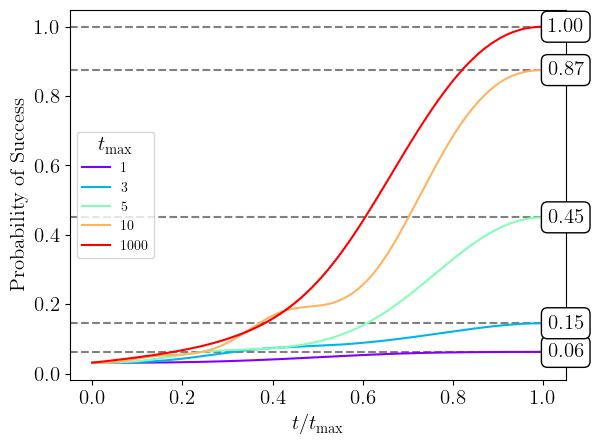

In [106]:
q = 1000
t_maxs = [1, 3, 5, 10, 1000]
# t_maxs = [1000]
phi_expected = generate_vector_j(19, n)

colours = cm.rainbow(np.linspace(0, 1, len(t_maxs)))

for i, t_max in enumerate(t_maxs):
    # Calculate the probabilities
    probs = generate_probabilities(q, t_max, H_ising, n, phi_expected)

    # Find the phi_expected component of the final state
    final_prob = probs[-1]
    print(t_max, final_prob)

    # Plot a dotted horizontal line at y=final_prob
    plt.axhline(final_prob, linestyle='--', color='gray')

    # Label the line
    plt.text(1.01, final_prob, f'{final_prob:.2f}', 
             va='center', ha='left', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    times = np.linspace(0, 1, q)
    plt.plot(times, probs, label=t_max, color=colours[i])

plt.xlabel(r'$t / t_\mathrm{max}$')
plt.ylabel('Probability of Success')
plt.legend(title=r'$t_\mathrm{max}$', fontsize='10')
# plt.savefig('milestone.png', transparent=True)

### Time-dependent controls plot

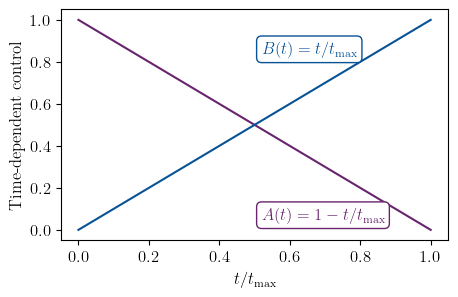

In [146]:
def A(t, t_max):
    return 1 - t/t_max

def B(t, t_max):
    return t/t_max

t_max = 100
t = np.linspace(0, t_max)

plt.figure(figsize=(5, 3))

plt.plot(t/t_max, A(t, t_max), color="#68246D")
plt.plot(t/t_max, B(t, t_max), color="#085296")

plt.text(0.52, 0.05, r'$A(t) = 1 - t/t_\mathrm{max}$', color="#68246D", bbox=dict(boxstyle='round,pad=0.3', edgecolor='#68246D', facecolor='white'))
plt.text(0.52, 0.84, r'$B(t) = t/t_\mathrm{max}$', color="#085296", bbox=dict(boxstyle='round,pad=0.3', edgecolor='#085296', facecolor='white'))

plt.xlabel(r'$t / t_\mathrm{max}$')
plt.ylabel('Time-dependent control')

plt.savefig('time_controls.png', transparent=True, bbox_inches='tight')

### Plot the energy of the system

In [72]:
print(np.sort(np.diag(H_ising)))

[-6.5 -5.5 -5.5 -5.5 -5.5 -4.5 -4.5 -4.5 -4.5 -4.5 -3.5 -2.5 -2.5 -1.5
 -1.5 -1.5 -1.5 -1.5 -1.5  0.5  1.5  1.5  1.5  1.5  1.5  4.5  5.5  5.5
  8.5  8.5 12.5 15.5]


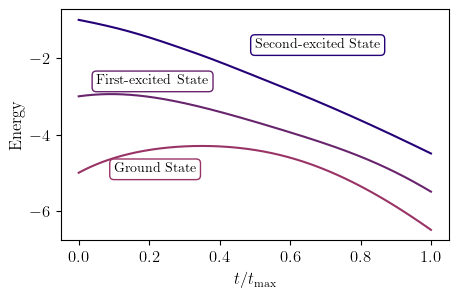

In [143]:
q = 1000
phi = generate_initial_wavefunction(n)
t_max = 100

plt.figure(figsize=(5, 3))

x = np.linspace(0, 1, q)

num_energies = 7

energies = np.zeros((num_energies, q))

for j in range(q):
    t = j * t_max / q
    H = time_dependent_H(t, t_max, H_ising, n)
    phi = evolve_phi(phi, t, t_max, q, H_ising, n)

    eigenvals, eigenvectors = np.linalg.eig(H)
    
    sorted_eigenvals = np.sort(eigenvals)
    k = 0
    m = 0
    energy = -np.inf

    while m < num_energies and k < len(sorted_eigenvals):
        # if not np.isclose(energy, np.round(sorted_eigenvals[k], 1)):
        energies[m, j] = sorted_eigenvals[k]
        m += 1
        k += 1

colours = ['#993366', '#68246D', '#250178']

for m in range(num_energies):
    if m in (0, 1, 6):
    # if True:
        plt.plot(x, energies[m], color=colours.pop(0))

colours = ['#993366', '#68246D', '#250178']
fontdict = {'fontsize':10}

plt.text(0.1, -5, 'Ground State', fontdict, bbox=dict(boxstyle='round,pad=0.3', edgecolor=colours.pop(0), facecolor='white'))
plt.text(0.05, -2.7, 'First-excited State', fontdict, bbox=dict(boxstyle='round,pad=0.3', edgecolor=colours.pop(0), facecolor='white'))
plt.text(0.5, -1.75, 'Second-excited State', fontdict, bbox=dict(boxstyle='round,pad=0.3', edgecolor=colours.pop(0), facecolor='white'))


plt.xlabel(r'$t / t_\mathrm{max}$')
plt.ylabel('Energy')

plt.savefig('energy_levels.png', transparent=True, bbox_inches='tight')


### Superposition animation

Define the basis matrix $B$

In [150]:
B = np.identity(2**n)

Create plot

In [151]:
def int_to_ket(i, n):
    # Convert an integer to the ket vector representation
    binary_str = format(i, f'0{n}b')
    return r'$|{} \rangle$'.format(binary_str)

kets = [int_to_ket(i, n) for i in range(2**n)]

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


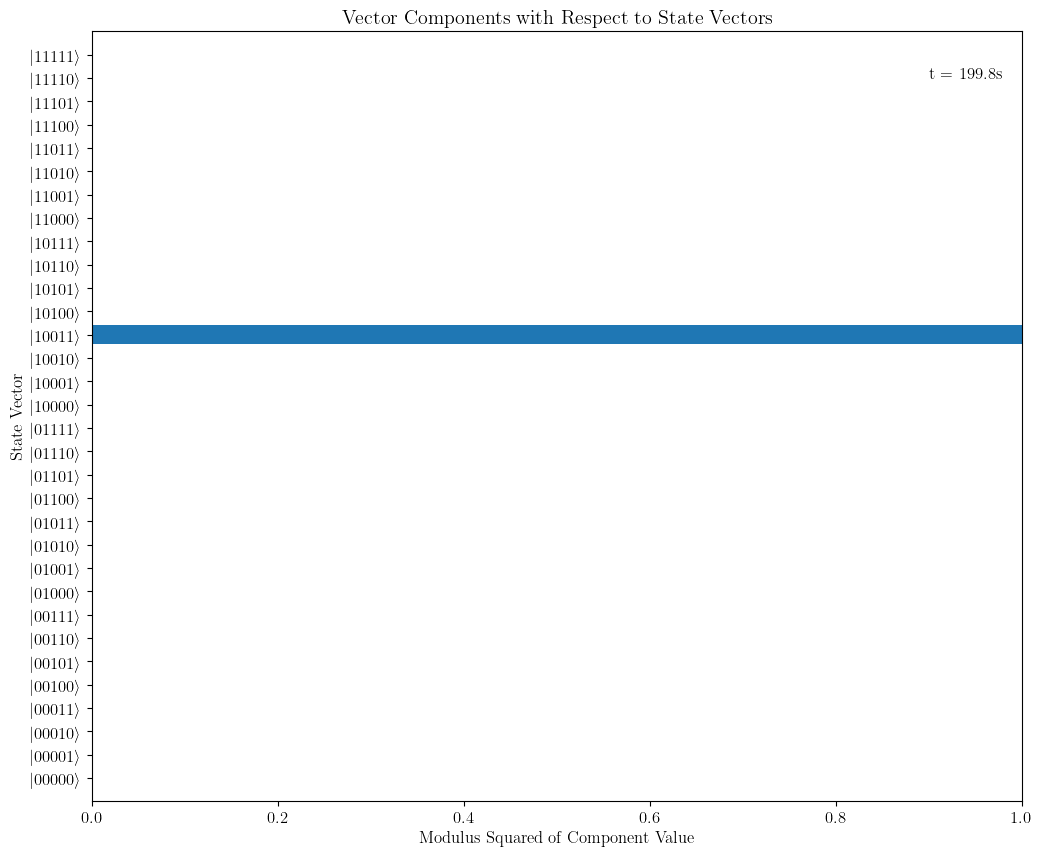

In [153]:
# Set up axis
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title('Vector Components with Respect to State Vectors')
ax.set_xlabel('Modulus Squared of Component Value')
ax.set_ylabel('State Vector')

ax.set_yticks(range(2**n))
ax.set_yticklabels(kets)

ax.set_xlim(0, 1)
ax.set_ylim(-1, 32)

t_max = 200
q = 1000
phi = generate_initial_wavefunction(n)

projections = ((np.abs(np.dot(phi.T, B)))**2)[0]
bar_width = 0.8  # Adjust as needed
bar_distance = 0.2  # Adjust as needed

bars = ax.barh(np.arange(len(projections)), projections, height=bar_width, align='center')

text = ax.text(0.9, 30, 't = 0s')

def update(j, t_max, q, H_ising, n):
    # Print progress
    if j % 10 == 0:
        print(j)

    # Calculate phi in this frame
    global phi
    phi = evolve_phi(phi, j*t_max/q, t_max, q, H_ising, n)

    # Calculate the projection of phi in the basis B
    projections = ((np.abs(np.dot(phi.T, B)))**2)[0]

    # Update the bars
    for bar, height in zip(bars, projections):
            bar.set_width(height)

    # Add t_max to the corner
    text.set_text('t = ' + str(j*t_max/q) + 's') 

anim = FuncAnimation(
    fig, 
    partial(update, t_max=t_max, q=q, H_ising=H_ising, n=n),
    frames=np.arange(0, q, 1), 
    interval=10
    )

# Set higher memory limit
matplotlib.rcParams['animation.embed_limit'] = 2**128

writergif = animation.PillowWriter(fps=30)
anim.save('t_max_new.gif',writer=writergif)

## Poster ideas

- Could add a QR code leading to gif - make gif look nicer
- Make graph look nicer 
- Talk more directly about results, what does the graph mean, what does success probability mean etc
    - Explain the superposition stuff better, describe the components thing
- Discuss t_max > 100 maybe? - could be worth changing the name from t_max because it's a bit misleading

- What matters is $\tau = t_\mathrm{max} / q$, the time each interval takes. Increasing $\tau$ gets us closer to a truly adiabatic process ($\lim \tau \rightarrow \infty$ for truly adiabatic process)
- Abstract needs changing